# Выпускной проект по курсу Аналитика данных. 
# E-commerce — Анализ товарного ассортимента

### Материалы:

<a href="https://disk.yandex.ru/i/iQDvRmJTBSe06g">Презентация проекта</a>

<a href="https://public.tableau.com/app/profile/zakh.pv/viz/Finalproject_16570552695730/Dashboard2">Дашборд проекта</a>


### Задача:

Проанализировать ассортимент товаров.

- Провести исследовательский анализ данных;
- Проанализировать торговый ассортимент;
- Сформулировать и провеить статистические гипотезы.

### Описание данных:

Датасет описывает транзакции интернет-магазина товаров для дома и быта.

Колонки в  *ecommerce_dataset.csv* :

- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

### ТЗ на дашборд:

1. Постройте диаграмму, отображающую сумму покупок по дням.
2. Постройте гистограмму, отображающую распределение заказов по сумме.
3. Добавьте фильтр дашборда по дате совершения покупки.

### Уточнение и декомпозиция задачи

Образ конечного результата: рекомендации по корректировке торгового ассортимента с целью повышения выручки. Форма: презентация + дашборд.

Этапы решения:

- Шаг 1: Изучение общей информации, подготовка данных.
- Шаг 2: Предобработка данных, исследование на шум, мусор и аномалии, устранение мусора.
- Шаг 3: Сравнительный анализ наслаивающихся периодов: октябрь 2018 и октябрь 2019. Поиск отличий как причин снижения выручки.
- Шаг 4: Сегментация торгового ассортимента 'product', подбор категорий.
- Шаг 5: Статистический анализ категорий: поиск самых популярных категорий и товаров, основных и подоплнительных товаров в заказе.
- Шаг 6: Поиск закономерностей покупок, формулирование и проверка статистических гипотез.
- Шаг 7: Сборка дашборда по набору:
  1. Постройте диаграмму количества покупок по дням.
  2. Добавьте индикатор количества покупателей.
  3. Добавьте фильтр дашборда по дате совершения покупки.
- Шаг 8: Выводы и рекомендации.

# Шаг 1: Импортируем и изучаем данные

In [189]:
import pandas as pd 
import numpy as np
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from plotly import graph_objects as go
import math as mth
import pandas_profiling
from pandas_profiling import ProfileReport
from pymystem3 import Mystem 
from collections import Counter
import re

In [190]:
df=pd.read_csv('/Users/z/Downloads/ecommerce_dataset.csv')

In [191]:
display(df.head(3))
display(df.info())
display(df.describe())

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


None

,date,order_id,quantity,price
count,6.737000e+03,6737.000000,6737.000000,6737.000000
mean,2.018855e+09,43128.948345,2.501559,462.028499
std,3.855185e+05,27899.414662,15.266478,871.296064
min,2.018100e+09,12624.000000,1.000000,9.000000
25%,2.019020e+09,14827.000000,1.000000,101.000000
50%,2.019050e+09,68503.000000,1.000000,135.000000
75%,2.019061e+09,70504.000000,1.000000,398.000000
max,2.019103e+09,73164.000000,1000.000000,14917.000000


In [192]:
#проверяем на нулевые значения и дубликаты
display(df.isna().sum())
print('Кол-во полных дубликатов', df.duplicated().sum())

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

Кол-во полных дубликатов 0


### Вывод: 
   - В датафрейме 6737 строк, нулевые значения и полные дубликаты отсуствуют
   - Необходимо преобразовать столбец date в формат datetime, столбец price в int
   - В столбце product привести все символы к нижнему регистру
   - В столбце quantity стандартное отклонение сильно больше среднего значения, необходимо проверить на выбросы
   - В столбце price максимальное значение сильно больше всех остальных, необходимо проверить на выбросы
   - Остальные проверки лучше проводить после преобразования даты
   
<div class="alert alert-info"> <b>Комментарий:</b> В данном исследовании мы совершаем "ошибку выжившего", потому что не анализируем товары, которые вообще не продались, их нет в нашей базе. Далее для анализа товарного ассортимента необходима выгрузка по всему каталогу товаров.</div>

# Шаг 2. Преобразуем данные, исследуем на шум и аномалии


### 2.1 Преобразуем данные

In [193]:
df['date'] =  pd.to_datetime(df['date'], format='%Y%m%d%H') #преобразуем дату в формат datetime
df['weekday'] = df['date'].dt.weekday #добавляем столбец weekday
df['week'] = df['date'].dt.week #добавляем столбец weekday
df['month'] = df['date'].dt.month #добавляем столбец month
df['year'] = df['date'].dt.year #добавляем столбец year
df['price'] = df['price'].astype('int') #переводим столбец price в формет int
df['revenue']= df['price']*df['quantity'] #создаем столбец выручки по заказу

### 2.2 Находим период исследования

In [194]:
print('Период исследования:', df['date'].min(),'-', df['date'].max())
print('Интервал исследования в днях:',df['date'].max()- df['date'].min())

Период исследования: 2018-10-01 00:00:00 - 2019-10-31 16:00:00
Интервал исследования в днях: 395 days 16:00:00


### 2.3 Изучаем уникальные значения

In [195]:
for i in df.columns:
    print('Уникальные значения столбца',i)
    display(df[i].unique()) 
    print('Число уникальных значений:', df[i].nunique())
    print('==========================================================================')

Уникальные значения столбца date


array(['2018-10-01T00:00:00.000000000', '2018-10-01T08:00:00.000000000',
       '2018-10-01T09:00:00.000000000', ...,
       '2019-10-31T13:00:00.000000000', '2019-10-31T14:00:00.000000000',
       '2019-10-31T16:00:00.000000000'], dtype='datetime64[ns]')

Число уникальных значений: 2606
Уникальные значения столбца customer_id


array(['ee47d746-6d2f-4d3c-9622-c31412542920',
       '375e0724-f033-4c76-b579-84969cf38ee2',
       '6644e5b4-9934-4863-9778-aaa125207701', ...,
       'f17ed857-178e-45e1-a662-0a9dd3b58c5f',
       '1f0a7f35-7459-4f23-b468-5e45bf481dd1',
       '25df96a7-c453-4708-9cea-a3dfc7c342ea'], dtype=object)

Число уникальных значений: 2451
Уникальные значения столбца order_id


array([68477, 68479, 68478, ..., 73158, 73162, 73164])

Число уникальных значений: 2784
Уникальные значения столбца product


array(['Комнатное растение в горшке Алое Вера, d12, h30',
       'Комнатное растение в горшке Кофе Арабика, d12, h25',
       'Радермахера d-12 см h-20 см', ...,
       'Сушилка для белья на ванну FREUDENBERG (GIMI) Alablock Varadero silver A4P',
       'Каланхое каландива малиновое d-7 см', 'Литопс Микс d-5 см'],
      dtype=object)

Число уникальных значений: 2343
Уникальные значения столбца quantity


array([   1,   10,   96,   15,    6,   11,    2,    4,    3,    5,   37,
         64,   25,  150,   50,   30,   17,    8,    9,    7,  170,   16,
        140,   27,   20,   12,   13,   24,  100,  200,   57,   40,   45,
         29,   23,   43,   14,   31,   59,   60,   18,   26,  300,   70,
        334, 1000,   22,   80,   65])

Число уникальных значений: 49
Уникальные значения столбца price


array([  142,   194,   112,   179,   164,   134,   824,   269,   674,
          82,   614,   187,    38,   188,   239,   262,  1049,  3299,
        1162,    89,   169,   101,    29,    59,   104,    22,    37,
          52,    49,    70,   374,   206,   202,   172,  3524,   150,
         299,  2924,    74,   119,    86,   749,   488,   592,  1649,
         127,  1762,   524,    67,  1409,   247,    97,  1949,    56,
        1874,   149,  5024,  3734,   315,   207,   162,   464,   412,
         427,  4949,  1349,  1574,  1199,   742,   712,  1724,    28,
         899,  1087,   937,   254,   209,   277,   292,   689,   697,
          60,    19,  2699,   449,    57,   599,   637,   525,    20,
        3899,    51,  1139,   314,  1012,   106,    71,  3089,   307,
          44,   434,   352,   539,   224,   217,   487,  2174,  2324,
         337,   562,   862,   300,  3974,   397,    27,   116,   128,
         734,   404,  1499,  1799,  2999,  2549,  1424,   509,   389,
        2399,   359,

Число уникальных значений: 360
Уникальные значения столбца weekday


array([0, 1, 2, 3, 4, 5, 6])

Число уникальных значений: 7
Уникальные значения столбца week


array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39])

Число уникальных значений: 52
Уникальные значения столбца month


array([10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9])

Число уникальных значений: 12
Уникальные значения столбца year


array([2018, 2019])

Число уникальных значений: 2
Уникальные значения столбца revenue


array([   142,    194,    112,    179,    164,    134,    824,    269,
          674,    820,    614,    187,   3648,    188,    239,    262,
         1049,   3299,   1162,     89,    169,    101,     29,     59,
          104,     22,     37,     52,    735,   1050,    374,   1236,
          202,    172,   1562,   3524,    150,    299,   2924,     74,
          119,    860,    749,    488,    592,   1649,    127,   1762,
          524,     67,   1409,    247,    494,    236,    177,    118,
          312,    295,   1949,    110,    840,   1874,    149,   3298,
         5024,   3734,    315,    207,    162,    254,    561,    808,
          568,    516,    464,    412,   1281,   4949,   1349,   1574,
         1199,    742,    712,   1724,    280,   1798,   1087,    937,
         1420,    209,    277,   7474,    292,    689,   1394,    120,
         1216,   2699,    449,   1425,    599,   1274,    525,    200,
         3899,   1275,   1139,    314,   1012,    637,    338,   1060,
      

Число уникальных значений: 651


### Вывод:
   - Период анализа 395 дней и 16 часов: с октября 2018 по октябрь 2019
   - 2451 покупатель
   - 2784 заказа
   - 2343 товарных позиции
   - В столбцах quantity и price присутсвуют выбросы

### 2.4 Изучаем аномалии

#### 2.4.1 Аномалии в сумме позиций заказов и стоимости

In [196]:
#выведем заказы с самым большим количеством позиций и самой большой суммой заказа
dfg = df.pivot_table(index = 'order_id', values = ['revenue'], aggfunc=['count','sum'])
dfg.columns = ['count','sum']
print('Заказы с самым большим количеством позиций:') 
display(dfg.sort_values('count', ascending = False).head(10).T) 
print('Заказы с самой большой стоимостью:')
display(dfg.sort_values('sum', ascending = False).head(10).T)
print('Статистические данные по количеству позиций и суммой заказов:')
display(dfg.describe().T)

Заказы с самым большим количеством позиций:


order_id,14833,14835,14753,14897,70960,14698,68760,14715,14500,14688
count,888,203,90,63,60,51,50,36,34,31
sum,114750,23660,3630,3476,65220,2922,50770,4558,5084,2280


Заказы с самой большой стоимостью:


order_id,71743,14833,70960,68760,69531,71668,69830,69156,69504,71148
count,1,888,60,50,12,1,1,6,1,16
sum,675000,114750,65220,50770,49668,49432,47385,33680,32718,32382


Статистические данные по количеству позиций и суммой заказов:


,count,mean,std,min,25%,50%,75%,max
count,2784.0,2.419899,17.657541,1.0,1.0,1.0,1.00,888.0
sum,2784.0,1742.557471,13308.290654,14.0,300.0,734.0,1612.75,675000.0


In [197]:
#Посчитаем 99 квантиль по количеству и сумме заказов
print('Пограничное значение количества товара в заказе', dfg['count'].quantile(.99).round())
print('Пограничное значение суммы заказа',(dfg['sum'].quantile(.99).round()))

Пограничное значение количества товара в заказе 18.0
Пограничное значение суммы заказа 11276.0


In [198]:
#Рассмотрим заказы с аномально большим количеством позиций и суммой заказа
#display(df.query('order_id==71743'))
#display(df.query('order_id==14833'))
#display(df.query('order_id==14835'))
#display(df.query('order_id==70960'))
#display(df.query('order_id==68760'))
#display(df.query('order_id==69531'))

### Вывод: 
В датафрейме присуствуют заказы с большим колличеством позиций.
Пример: Заказ 70960 содержит 60 одинаковых строк, но с разной датой/временем. Скорей всего этот заказ создан ошибочно, например клиент многократно нажал на кнопка "заказать". Найдем аналогичные заказы и удалим дубликаты. Заказы удаляем по фильтру "одинаковые 'customer_id', 'order_id','product'".

In [199]:
#удаляем дубликаты, смотрим на результат
df = df.drop_duplicates(subset=['customer_id', 'order_id','product'], keep='last')

display(df.info())
dfg = df.pivot_table(index = 'order_id', values = ['revenue'], aggfunc=['count','sum'])
dfg.columns = ['count','sum']

print('Заказы с самым большим количеством позиций:') 
display(dfg.sort_values('count', ascending = False).head(10).T) 
print('Заказы с самой большой стоимостью:')
display(dfg.sort_values('sum', ascending = False).head(10).T)
print('Статистические данные по количеству позиций и суммой заказов:')
display(dfg.describe().T)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4851 entries, 0 to 6736
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         4851 non-null   datetime64[ns]
 1   customer_id  4851 non-null   object        
 2   order_id     4851 non-null   int64         
 3   product      4851 non-null   object        
 4   quantity     4851 non-null   int64         
 5   price        4851 non-null   int64         
 6   weekday      4851 non-null   int64         
 7   week         4851 non-null   int64         
 8   month        4851 non-null   int64         
 9   year         4851 non-null   int64         
 10  revenue      4851 non-null   int64         
dtypes: datetime64[ns](1), int64(8), object(2)
memory usage: 454.8+ KB


None

Заказы с самым большим количеством позиций:


order_id,14698,14715,14688,14753,14705,14835,14827,14897,14848,14778
count,51,36,31,30,29,29,27,26,26,25
sum,2922,4558,2280,1210,3776,3380,4187,1457,3970,2090


Заказы с самой большой стоимостью:


order_id,71743,71668,69830,69156,69504,68878,68760,70080,71206,71478
count,1,1,1,6,1,1,21,1,1,1
sum,675000,49432,47385,33680,32718,24370,22056,16536,15680,15300


Статистические данные по количеству позиций и суммой заказов:


,count,mean,std,min,25%,50%,75%,max
count,2784.0,1.742457,2.796766,1.0,1.0,1.0,1.0,51.0
sum,2784.0,1484.933190,12964.172677,14.0,292.0,689.0,1476.5,675000.0


In [200]:
#посмотрим выборочно аномальные заказы после удаления дубликатов
#display(df.query('order_id==14833'))
#display(df.query('order_id==14835'))
#display(df.query('order_id==70960'))

### Вывод: 
После удаления неполных дубликатов данные выглядят чище. Осталось 4851 строк из 6737, 72% датафрейма.

#### 2.4.2 Аномалии в количестве единиц товара в заказе

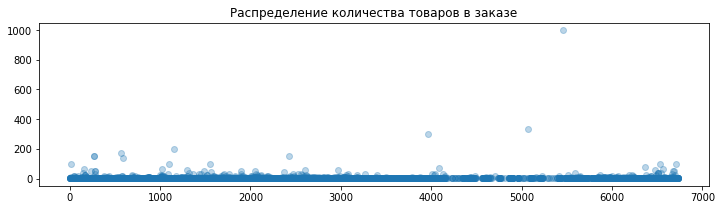

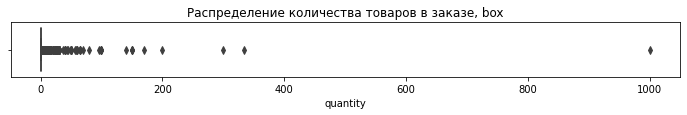

In [201]:
#Посмотрим на распределение количества товаров в заказе
plt.figure(figsize=(12,3))
df['quantity'].plot(style = 'o',alpha = 0.3);
plt.title('Распределение количества товаров в заказе')
plt.show()

plt.figure(figsize=(12,1))
sns.boxplot(x='quantity', data=df) 
plt.title('Распределение количества товаров в заказе, box')
plt.show()

In [202]:
print('Граница 99 персентиля количества товара (считаем оптовыми заказами):',df['quantity'].quantile(.99).round())
print('Оптовых заказов:', df.query('quantity>30')['order_id'].count())
print('Выручка по оптовым заказам:', (df.query('quantity>30')['price']*df.query('quantity>30')['quantity']).sum())
print('Полная выручка по датасету', (df['price']*df['quantity']).sum())
print('Доля выручки по оптовым товарам', (((df.query('quantity>30')['price']*df.query('quantity>30')['quantity']).sum()/(df['price']*df['quantity']).sum())*100).round(2))

Граница 99 персентиля количества товара (считаем оптовыми заказами): 30.0
Оптовых заказов: 41
Выручка по оптовым заказам: 935069
Полная выручка по датасету 4134054
Доля выручки по оптовым товарам 22.62


In [203]:
#удаляем выбросы
df=df.query('quantity<=30')

### Вывод:
Для принятия решения по удалению заказов с аномально высоким количеством товаров необходимо уточнить у заказчика, являются ли эти заказы ошибочными или это реальные заказы и их стоит учитывать в исследовании. Так как 22,6% готовой выручки - существенная доля.

Склоняюсь, что 41 заказ не могут дать 22.6% и в рамках работы примем допущение, что это ошибочные заказы и удалим их. Вместе с ними удаляется и часть товарных позиций. НО так как мы работаем в условиях "ошибки выжившего" и анализируем только проданные товары, проданными ошибочно так же можно пренебречь.

#### 2.4.3 Аномалии в стоимости заказов

Заказы с самой большой стоимостью:


order_id,69830,68878,68760,70080,71206,72139,71205,71598,70135,14735
revenue,47385,24370,22056,16536,15680,14917,14196,11400,11000,10656


,count,mean,std,min,25%,50%,75%,max
revenue,2749.0,1163.690433,1791.121309,14.0,284.0,674.0,1424.0,47385.0


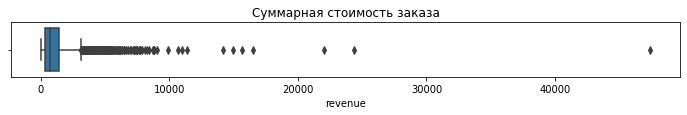

In [204]:
#построим на самые дорогие заказы
df_price_by_order = df.pivot_table(index=['order_id'], values='revenue', aggfunc='sum')
print('Заказы с самой большой стоимостью:')
display(df_price_by_order.sort_values('revenue', ascending = False).head(10).T) 
display(df_price_by_order.describe().T)

plt.figure(figsize=(12,1))
sns.boxplot(x='revenue', data=df_price_by_order) 
plt.title('Суммарная стоимость заказа')
plt.show()

#display(df.query('order_id==69830')) #рассмотрим самые крупные заказы
#display(df.query('order_id==68878')) #рассмотрим самые крупные заказы

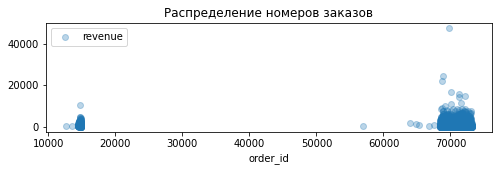

In [205]:
#построим распределение номеров заказов
df_price_by_order.plot(style = 'o',alpha = 0.3, figsize=(8, 2));
plt.title('Распределение номеров заказов')
plt.show()

In [206]:
#рассмотрим самые крупные заказы
#display(df.query('order_id==68760'))
#display(df.query('order_id==72139'))

In [207]:
#вычислим границу 99 персентиля по цене заказа
display(df_price_by_order['revenue'].quantile(.99).round())

7388.0

### Вывод:
- 99 персентиль аномальной суммы заказа 7388. Но два самых крупных заказа нельзя назвать аномальными, это просто из ряда вон крупная закупка в заказе 68760 и один дорогой товар в заказе 72139. Мы не будем их удалять, так как это не влияет на товарный ассортимент и заинтересованность в нем. Наоборот стоит обратить внимание, что товары высоких ценовых категорий в данном магазине не пользуются популярностью.
- Так же вижно, что нумерация заказов бьется на две части. Интервал 14000-15000 и 68000-75000. Аномалия не дает мне покоя, но интерпретировать ее не удалось, возможно просто сменили нумерацию, чтобы клиентам казалось, что заказов больше, чем есть на самом деле.

#### 2.4.4 Аномалии по количеству заказов на покупателя

Клиенты с самым большим числом заказов:


,customer_id,count
1888,c971fb21-d54c-4134-938f-16b62ee86d3b,125
729,4d93d3f6-8b24-403b-a74b-f5173e40d7db,33
1082,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17
1722,b7b865ab-0735-407f-8d0c-31f74d2806cc,7
17,0184f535-b60a-4914-a982-231e3f615206,5


,count,mean,std,min,25%,50%,75%,max
count,2418.0,1.149297,2.643256,1.0,1.0,1.0,1.0,125.0


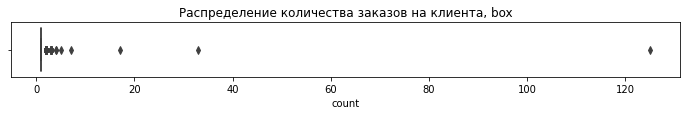

Граница 99 персентиля количества заказов на одного клиента за 395 дней: 3.0


In [208]:
#Посмотрим на распределение количества заказов на покупателя
orders_by_customer = df.groupby('customer_id', as_index=False).agg({'order_id':'nunique'})
orders_by_customer.columns = ['customer_id','count']

print('Клиенты с самым большим числом заказов:')
display(df_orders_by_customer.sort_values(by='count',ascending=False).head(5))
display(df_orders_by_customer.describe().T)

plt.figure(figsize=(12,1))
sns.boxplot(x='count', data=df_orders_by_customer) 
plt.title('Распределение количества заказов на клиента, box')
plt.show()

print('Граница 99 персентиля количества заказов на одного клиента за 395 дней:',orders_by_customer['count'].quantile(.99).round())

### Вывод: 
Удалять заказы по персентелю нет необходимости: 5-7 заказов в год выглядит нормальным. Есть три клиента, сделавшие 17, 33 и 125 заказов за 395 дней. Для магазина продуктов это выглядело бы нормально, но не для магазина рассады.
Но опять же данная аномалия скорей всего ошибка базы и не влияет на товарный ассортимент. Возможно офлайн или корпоративных клиентов записывали в базу под этими id. Аномалию стоит удалить только для анализа товара с разбивкой по клиентам.

### 2.5 Результат предобработки и вывод по аномалиям

In [209]:
#смотрим результат предобработки
display(df.head(3))
display(df.info())
display(df.describe())
for i in df.columns: 
    print('Число уникальных значений столбца',i, df[i].nunique())

,date,customer_id,order_id,product,quantity,price,weekday,week,month,year,revenue
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142,0,40,10,2018,142
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194,0,40,10,2018,194
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112,0,40,10,2018,112


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4810 entries, 0 to 6736
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         4810 non-null   datetime64[ns]
 1   customer_id  4810 non-null   object        
 2   order_id     4810 non-null   int64         
 3   product      4810 non-null   object        
 4   quantity     4810 non-null   int64         
 5   price        4810 non-null   int64         
 6   weekday      4810 non-null   int64         
 7   week         4810 non-null   int64         
 8   month        4810 non-null   int64         
 9   year         4810 non-null   int64         
 10  revenue      4810 non-null   int64         
dtypes: datetime64[ns](1), int64(8), object(2)
memory usage: 450.9+ KB


None

,order_id,quantity,price,weekday,week,month,year,revenue
count,4810.000000,4810.000000,4810.000000,4810.000000,4810.000000,4810.000000,4810.000000,4810.000000
mean,48076.431601,1.931809,519.663617,2.630353,26.602495,6.510187,2018.748857,665.069647
std,27370.773242,3.236747,949.222770,1.967334,14.255839,3.289902,0.433716,1369.426536
min,12624.000000,1.000000,9.000000,0.000000,1.000000,1.000000,2018.000000,9.000000
25%,14770.250000,1.000000,90.000000,1.000000,16.000000,4.000000,2018.000000,120.000000
50%,68855.000000,1.000000,150.000000,2.000000,23.000000,6.000000,2019.000000,190.000000
75%,70813.500000,1.000000,509.000000,4.000000,41.000000,10.000000,2019.000000,727.000000
max,73164.000000,30.000000,14917.000000,6.000000,52.000000,12.000000,2019.000000,47385.000000


Число уникальных значений столбца date 2215
Число уникальных значений столбца customer_id 2418
Число уникальных значений столбца order_id 2749
Число уникальных значений столбца product 2323
Число уникальных значений столбца quantity 27
Число уникальных значений столбца price 356
Число уникальных значений столбца weekday 7
Число уникальных значений столбца week 52
Число уникальных значений столбца month 12
Число уникальных значений столбца year 2
Число уникальных значений столбца revenue 619


## Общий вывод по предобработке данных:

- Период анализа 395 дней и 16 часов: с октября 2018 по октябрь 2019
- В сырых данных содержалось 6737 строк:
   - 2451 уникальный покупатель
   - 2784 уникальных заказа
   - 2343 товарных позиции
- После удаления аномалий и мусора осталось 4810 строки:
   - 2418 уникальный покупатель
   - 2749 уникальных заказа
   - 2323 товарных позиции
- Устранены аномалии дублирующих заказов, выбросы по количеству товара в заказе. 
- Так же обнаружена аномалия присвоения одного номера заказа разным пользователям, но это не влияет на анализ товарного ассортимента, мы ее так же пропускаем.

## Шаг 3: Сравнительный анализ наслаивающихся периодов: октябрь 2018 и октябрь 2019. Поиск отличий как причин снижения выручки.

In [210]:
def oct_check(y): #функция принимает на вход год и выводит ряд параметров, соответствующих этому коду
    dfy = df[(df['year'] == y)&(df['month'] == 10)]
    print('Суммарная выручка в октябре', y,':', dfy['revenue'].sum())
    print('Число заказов в октябре', y,':', len(dfy.groupby('order_id')))
    print('Средний чек в октябре', y,':', dfy.groupby('order_id')['revenue'].sum().mean().astype(int))
    print('Среднее число позиций в заказе в октябре', y,':', dfy.groupby('order_id')['product'].count().mean().round(1))
    print('Среднее количество товаров в заказе в октябре', y,':', dfy.groupby('order_id')['quantity'].sum().mean().round(1),'\n')
    
oct_check(2018)
oct_check(2019)

print('Процент падения выручки', (100-df.query('year==2019 & month == 10')['revenue'].sum()/df.query('year==2018 & month == 10')['revenue'].sum()*100).round(2))

Суммарная выручка в октябре 2018 : 324784
Число заказов в октябре 2018 : 232
Средний чек в октябре 2018 : 1399
Среднее число позиций в заказе в октябре 2018 : 2.0
Среднее количество товаров в заказе в октябре 2018 : 3.9 

Суммарная выручка в октябре 2019 : 195573
Число заказов в октябре 2019 : 195
Средний чек в октябре 2019 : 1002
Среднее число позиций в заказе в октябре 2019 : 1.1
Среднее количество товаров в заказе в октябре 2019 : 2.1 

Процент падения выручки 39.78


Корреляция признаков заказов:


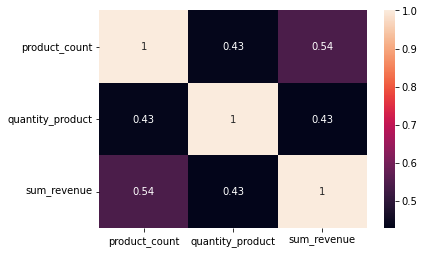

In [211]:
#Проверим корреляцию признаков: число позиций товаров в заказе, количество товара в заказе от стоимости заказа
print('Корреляция признаков заказов:')
corr_check = df[(df['year'] == 2018)&(df['month'] == 10)].groupby('order_id').agg({'product':'count','revenue':'sum','quantity':'sum'})
corr_check.columns = ['product_count', 'quantity_product','sum_revenue']
sns.heatmap((corr_check).corr(), annot=True);


### Вывод: 
При сравнении двух одинаковых периодов (октябрь 2018 и октябрь 2019) видим сильное падение выручки, практически на 40%.

При этом число заказов снизилось не так значительно, только на 16%, а средний чек на 28%.
Значительное изменение произошло в среднем количестве товаров в заказе: в 2018 в заказе присутствовало в среднем 2 товара, в 2019 только 1. Так же почти вдвое снизилось количество товаров одной позиции в заказе с 3.9 до 2.1.
#### Магазин потерял 40% выручки в первую очередь за счет отсуствия дополнительных товаров в заказе и снижения количества товаров одного типа в заказе.

## Шаг 4. Исследовательский анализ
### 4.1 Общие данные

In [212]:
print('Суммарная выручка за весь период:', df['revenue'].sum())
print('Число заказов:', len(df.groupby('order_id')))
print('Средний чек:', df.groupby('order_id')['revenue'].sum().mean().astype(int))
print('Среднее число позиций в заказе:', df.groupby('order_id')['product'].count().mean().round(1))

Суммарная выручка за весь период: 3198985
Число заказов: 2749
Средний чек: 1163
Среднее число позиций в заказе: 1.7


 ### 4.2 Матрица корреляции

Матрица корреляции датафрейма:


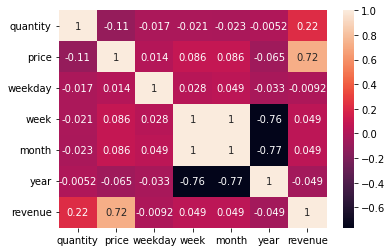

In [213]:
print('Матрица корреляции датафрейма:')
sns.heatmap(df.drop(columns='order_id').corr(), annot=True);

### Вывод:
Целевые параметры (количество, цена, даты) практически не коррелируют

 ### 4.3 Анализ стоимости товаров и выручки

In [214]:
#Распределение товаров по цене и количеству в заказе
df_product = df.pivot_table(index=['product'], values=['price','quantity','revenue'],aggfunc={'price':'max','quantity':'sum','revenue':'sum'})
df_product.columns=['price','quantity','revenue']
display(df_product.describe().T)

,count,mean,std,min,25%,50%,75%,max
price,2323.0,644.367628,1141.277012,9.0,90.0,188.0,712.0,14917.0
quantity,2323.0,4.000000,7.818516,1.0,1.0,2.0,4.0,105.0
revenue,2323.0,1377.092122,2777.157955,9.0,187.0,488.0,1424.0,53232.0


1711

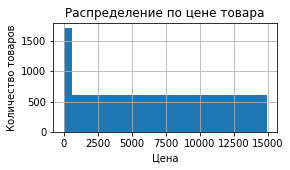

In [215]:
#построим распределение по ценовым категориям
df_product['price'].hist(bins = (0,644,14917), figsize=(4, 2))
plt.title('Распределение по цене товара')
plt.xlabel('Цена')
plt.ylabel('Количество товаров');
df_product[df_product['price']<645]['price'].count()

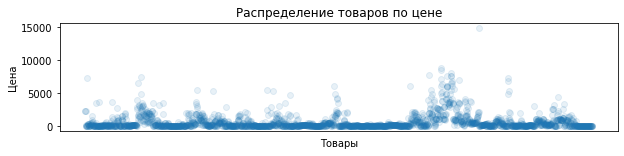

In [216]:
#Построим распределение товаров по стоимости
plt.figure(figsize=(10,2))
df_product['price'].plot(style = 'o',alpha = 0.1);
plt.title('Распределение товаров по цене')
plt.ylabel('Цена')
plt.xlabel('Товары');
plt.xticks([])
plt.show()

In [217]:
#Посмотрим топ-5 самых дорогих товаров
display(df_product.sort_values('price', ascending = False).head(5))

,price,quantity,revenue
product,,,
Сушилка уличная Leifheit 85210 LINOMATIC V 400 40 м 175х237х237 см зеленая,14917,1,14917
"Сумка-тележка хозяйственная Andersen Royal Shopper, Hera, синяя 166-004-90",8737,1,8737
"Сумка-тележка хозяйственная Andersen Alu Star Shopper, Hava, синяя 115-103-90",8437,1,8437
Сумка-тележка хозяйственная Rolser MNB019 rojo LOGIC DOS+2 красная,8077,1,8077
Стремянка 7 ступенчатая Hailo 8040-707 XXL 13 см алюминиевая с лотком для инструментов,7724,1,7724


In [218]:
#Найдем топ-5 товаров по выручке
df_product_by_revenue = df.groupby('product', as_index=False).agg({'revenue':'sum','price':'max', 'quantity':'sum'})
df_product_by_revenue.columns = ['product','sum', 'price', 'quantity']
display(df_product_by_revenue.sort_values(by='sum',ascending=False).head(5))

,product,sum,price,quantity
1183,Простынь вафельная 200х180 см WELLNESS RW180-0...,53232,1949,30
1605,Сумка-тележка 2-х колесная Gimi Argo синяя,50405,1087,47
1631,Сумка-тележка хозяйственная Andersen Scala Sho...,28045,6149,5
1936,"Урна уличная ""Гео"", Hobbyka/Хоббика, 59*37,5см...",24370,4874,5
131,"Веник сорго с деревянной ручкой с 4-мя швами, ...",20010,550,37


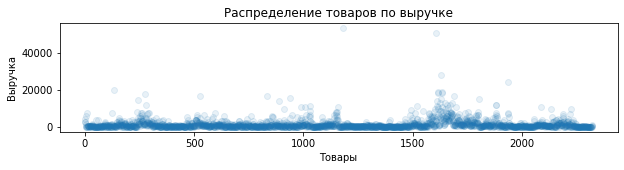

In [219]:
#Построим распределение товаров по выручке
plt.figure(figsize=(10,2))
df_product_by_revenue['sum'].plot(style = 'o',alpha = 0.1);
plt.title('Распределение товаров по выручке')
plt.ylabel('Выручка')
plt.xlabel('Товары');
plt.show()

,order,revenue
count,2749.000000,2749.000000
mean,64574.526737,1163.690433
std,17605.163910,1791.121309
min,12624.000000,14.000000
25%,69111.000000,284.000000
50%,70452.000000,674.000000
75%,71849.000000,1424.000000
max,73164.000000,47385.000000


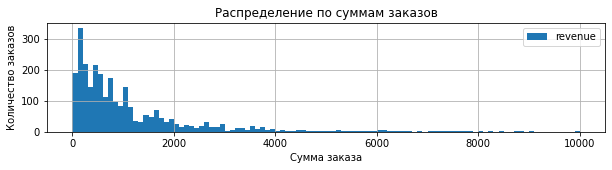

In [220]:
#Построим распределение по суммам заказов
df_id = df.groupby('order_id')['revenue'].sum().reset_index()
df_id.columns=['order','revenue']
display(df_id.describe())
df_id.plot(y = 'revenue', kind = 'hist', bins = 100, grid=True, range = (1,10000),figsize=(10,2))
plt.title('Распределение по суммам заказов')
plt.ylabel('Количество заказов')
plt.xlabel('Сумма заказа');
plt.show()

1946

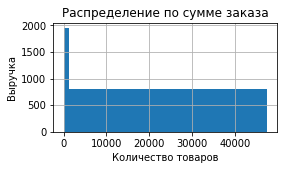

In [221]:
#построим распределение по ценовым категориям
df_id['revenue'].hist(bins = (0,1163,47385),figsize=(4, 2))
plt.title('Распределение по сумме заказа')
plt.ylabel('Выручка')
plt.xlabel('Количество товаров');
#найдем количество заказов меньше среднего значения
df_id[df_id['revenue']<1163]['revenue'].count()

### Вывод:
- Суммарная выручка за весь период: 3198985
- Число заказов: 2749
- Средняя цена товара: 645, но более 1700 товаров (74%) попали в ценовую категорию ниже среднего. Товары низкой ценовой категории преобладают в ассортименте.
- Средний чек: 1163, но большинство заказов так же меньше среднего чека (1946 из 2749)
- Среднее число позиций в заказе: 1.7

### 4.4 Анализ выручки по времени

,0,1,2,3,4,5,6,7,8,9,10,11,12
year,2018,2018,2018,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019
month,10,11,12,1,2,3,4,5,6,7,8,9,10
revenue,324784,313594,304888,220102,302159,252969,302158,216485,185766,226361,181253,172893,195573


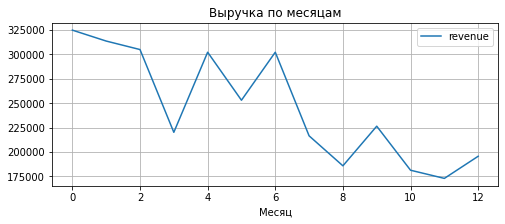

In [222]:
#Посмотрим на суммарную выручку по месяцам
revenue_by_month = df.pivot_table(index=['year','month'], values='revenue', aggfunc='sum').reset_index()
revenue_by_month.plot(kind='line', grid=True, y=['revenue'], title='Выручка по месяцам', figsize=(8, 3))
display(revenue_by_month.T)
plt.xticks(rotation=0)
plt.xlabel('Месяц');

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
year,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,...,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019
week,40,41,42,43,44,45,46,47,48,49,...,35,36,37,38,39,40,41,42,43,44
revenue,76250,68951,69932,74581,70714,127595,34594,60638,67419,61583,...,41421,38575,41635,44211,41042,43384,52455,58283,30441,14388


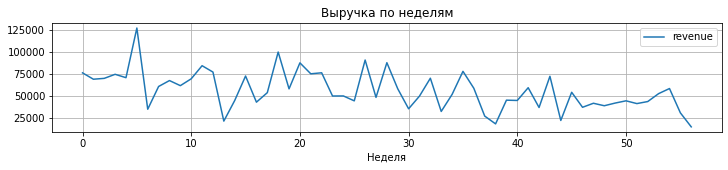

In [223]:
#Посмотрим на суммарную выручку по неделям
revenue_by_month = df.pivot_table(index=['year','week'], values='revenue', aggfunc='sum').reset_index()
revenue_by_month.plot(kind='line', grid=True, y=['revenue'], title='Выручка по неделям', figsize=(12, 2))
display(revenue_by_month.T)
plt.xticks(rotation=0)
plt.xlabel('Неделя');

,0,1,2,3,4,5,6
weekday,0,1,2,3,4,5,6
revenue,539288,596072,507177,496362,451315,262054,346717


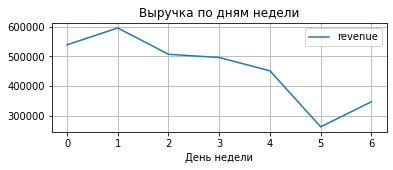

In [224]:
#Посмотрим на суммарную выручку по дням недели
revenue_by_month = df.pivot_table(index=['weekday'], values='revenue', aggfunc='sum').reset_index()
revenue_by_month.plot(kind='line', grid=True, y=['revenue'], title='Выручка по дням недели', figsize=(6, 2))
display(revenue_by_month.T)
plt.xticks(rotation=0)
plt.xlabel('День недели');

### Вывод:
- Наблюдаем падение выручки в исследуемый период
- Матрица корреляции показала, что в исходном датафрейме нет параметров, коллелирующих между собой. Только те, что мы вывели сами из исходных, их корреляция логияна.
- Выручка по месяцам и неделям носит сезонный характер, в выходные выручка падает, освновные месяцы с высокими продажами: с февраля по май.


- Суммарная выручка за весь период: 3198985
- Число заказов: 2749
- Средняя цена товара: 645, но более 1700 товаров (74%) попали в ценовую категорию ниже среднего. Товары низкой ценовой категории преобладают в ассортименте.
- Средний чек: 1163, но большинство заказов так же меньше среднего чека (1946 из 2749)
- Среднее число позиций в заказе: 1.7

## Шаг 5. Сегментация

Выявлена основная проблема: среднее количество товаров в заказе низкое. 
Чтобы повысить выручку, нужно мотивировать клиента добавить в заказ дополнительные товары. Какие?

Чтобы выяснить это, добавим товарам несколько дополнительных признаков и сегментируем товары по ним:

- Функциональные категории (хоз. товары, растения, декор, инструменты и т.д.). 

Подбирать категории будем последовательно в ходе анализа товарного ассортимента.

- Оптовый/розничный товар 

Оптовые товары обычно закупают партией, например семена редко покупают 1 упаковку. На такой товар имеет смысл ставить акции "при покупке 5 шт шестая бесплатно" и тп. Оптовым будем считать любой товар, который покупают более 1 в заказе. Границу акции определяем как "среднее количество товара за покупку" + 1 шт. То есть провоцируем на покупку как минимум еще 1 штуки.

- Единичный/комплектный товар 

Комплектные товары чаще покупают вместе с другими (карандаш+ластик, огурцы+помидоры). В идеале найти каждому товару самую эффективную пару в "комплект". Поиск парного товара будем осуществлять по следующему алгоритму:
           1. Отбираем заказы с 2 и более товарами
           2. Определяем "основной" товар - самый дорогой в заказе
           3. Смотрим все товары, которые попадали с ним в одну корзину, сортируем по выручке
           4. Выбираем самый популярный

- Сезонность (месяц/неделя)

В зависимости от сезона предлагать товары из популярных в этот период (в мае закупают рассаду, в августе устройства для сбора урожая). Какую сезонность использовать: по месяцам или по номерам недель, необходимо выяснить по результам A/B теста после примерения рекомендаций.

### 5.1 Лемматизация

In [225]:
# приведем наименование товара к нижнему регистру
df['product'] = df['product'].str.lower() 

In [226]:
unique_product = df['product'].unique() # создаем список уникальных товаров
m = Mystem()
string = '; '.join(unique_product) # сохраным результат в переменной string
lemmas = m.lemmatize(string) # проводим лемматизацию
print('Всего лемм', len(Counter(lemmas)))

Всего лемм 4597


In [227]:
#удаляем все слова более 2 символов
lemmas = [x for x in lemmas if len(x) > 2] 
print('Теперь лемм', len(Counter(lemmas)))

Теперь лемм 4307


In [228]:
#удаляем все слова с цифрами и латиницей с помощью цикла
test_str = '1234567890abcdefghijklmnopqrstuvwxyz'
res = []
for sub in lemmas:
    flag = 0
    for ele in sub:
        if ele in test_str:
            flag = 1
    if not flag:
        res.append(sub)
lemmas = res
print('Теперь лемм', len(Counter(lemmas)))

Теперь лемм 2085


In [229]:
#удаляем глаголы и прилагательные с помощью регулярных выражений по признаку "оканчивается на ий, ой, ый и ть"
res = []
for word in lemmas:
    if (re.findall('[А-я]+ый', word) == []) and (re.findall('[А-я]+ой', word) == []) and (re.findall('[А-я]+ть', word) == [])and (re.findall('[А-я]+ий', word) == []):
        res.append(word)
lemmas = res
print('Теперь лемм', len(Counter(lemmas)))

Теперь лемм 1520


In [230]:
#Начинаем собирать каталог
#display(Counter(lemmas))

### 5.2 Категоризация по функциональной категории товара
Категории подбираем отталкиваясь от самых продаваемых товаров, чтобы выделить "специализацию" магазина. Если товар по слову не однозначно подходит к категории и может залететь в несколько ("чехол", "емкость", "растение","ковш"), вписываем его в словарь вместе с пояснительным словом ("чехол для доски"). Либо вписываем другое определяющее слово из названия, однозначно подходящее категории ("микрофибра", "махровый", "хранение"). Если слова склоняются - убираем окончания ("из микрофибры" - "микрофибр"), короткие менее 4 символов слова не используем в одиночку.

In [231]:
catalog = {
    'декор':['муляж','искусственный','искусственная','искусственных','искуственных','ящик почтовый','картина','фоторамка',
             'декоративная коробка','подставка для цветов'],
    
    'растения и рассада':['арбуз','декабрист','калибрахоа','кассете','пеларгония','петуния','рассада','табак','тюльпаны розовые',
        'томата','циперус','радермахера','хлорофитум','хризолидокарпус','черенок','эвкалипт гунни','колокольчик',
        'эхинокактус','гвоздика','плантация','тимьян','эпипремнум','примула','комнатная','базилик','дендробиум',
        'ранункулус','лобелия','дыня','папоротник','виноград','седум','цинния','эхеверия','спатифиллум','эвкалипт','камнеломка',
        'хоста','горшке','хамедорея','юкка','рукола','каланхое','хризантема','овсянница','розмарин','драцена','вербена',
        'мединилла','мимоза','гиацинт','фиалка','бальзамин','аптения','подсолнечник','вербейник','цикламен','пуансеттия','мирт',
        'кореопсис','ясколка','георгина','алиссум','чабер','котовник','монарда','лапчатка','укроп','подвесное кашпо','комнатн',
        'годеция','бегония','энотера','антуриум','эшшольция','цинерария','рудбекия','петрушка','анемона','бадан','скиммия',
        'барвинок','бархатцы','настурция','гайлардия','пиретрум','физостегия','земляника','огурец','флокс','калла','46500',
        'кипарисовик','душица','львиный зев','лаватера','морковь','солидаго','бакопа ампельная','пуансетия','мята','гардения',
        'лилейник','небесная лазурь','календула','гипсофила','шеффлера','глоксиния','алоэ','нобилис','тюльпан louvre','подарочный набор'
        'скиммия','адиантум','фаленопсис','пеперомия','аквилегия','вероника','калатея','альбука','сантолина','артемизия',
        'аспарагус','пряные травы','астра','пахира','афеляндра','смолевка','патиссон','лавр d','баклажан','бузульник','гербера','соланум',
        'гимнокалициум','суккулент','46600','гортензия','джункус','тыква','диффенбахия','фатсия','незабудка','фикус','замиокулькас',
        'нефролепис','зверобой','фиттония','импатиенс','нолина','осина','муррайя','иссоп','цитрофортунелла','кабачок','каллуна',
        'молодило','эхинацея','калоцефалус','кампанула','капсикум','крассула','лантана','литопс','мелисса','новогоднее дерево',
        'коника','капуста','ампельная','чашелистом','томат балконное','индика','рогатая','кордана','патио','роза мини','роза палас',
        'нивянник','лаванда торх','лаванда d','горох амброзия','кофе арабика','клубника альба','клубника мара','клубника хоней'],
    
    'тележки':['сумка','тележка','шнур резиновый для тележки'],
    
    'сушилки':['сушилк'],
    
    'для хранения':['чехол для одежды','вешал','хранение','плечики','чехол для костюма','корзин','чехол для платья','кофр',
        'чехол для короткой','вакуумный пакет','коробка для хранения','ящик для хранения'],
    
    
    'мебель':['комод','детский пуф','полки qwerty','этажерка','стеллаж','полка','обувница'],
                            
    
     'техника':['весы напольные','пылесос','электр','фен дорожный','пьезозажигалка','кипятильник','соковыжималка','электроштопор',
        'миксер','tepмокружка','термокружка','светильник','утюг delta'],  
    
    'гладильные доски':['гладильн','подкладка под чехол','подрукавник','глажен'],
    
    'посуда':['тарелка','нож','половник','блюдце','емкость для соуса','салатник','свч','стакан','ложка','вилка','банка',
        'миска','чайный набор','лоток','хлебница','блюдо','рыбочистка','овощеварка','бокал','кастрюл','термос','столов','бульонница',
        'скалка','скребок кондитерский','фужер','венчик','посуда','орехоколка','тортница','соковарка','картофелемялка',
        'чайник со свистком','чайник заварочный','форма для выпечки','лопатка','мантоварка','терка','толкушка','разделочная',
        'просеиватель','сахарница','сито','сковорода','сотейник','отделитель косточек','набор форм','для выпечки','кондитер','овощечистка',
        'противень','кружка нордик','кружка прозрачная','кружка бамбук','rosario','кружка для','luminarc','мерная','чайник эмалированный',
        'салфетница','подставка для яйца','защитный экран','вкладыши для хранения','набор посуды','пресс для чеснока'],
    
    'текстиль':['наматрацник','наматрицник','одеяло','белье','плед','простын','полотен','наматрасник','покрывало','наволочка',
        'пододеяльник','подушка','халат','ковр','ковер','ковёр','комплект для ванной','салфетка','скатерть'],
    
    'ремонт':['инструмент','сверел','сверло','напильник','стяжк','штангенциркуль','стяжка','крючок','уголок',
        'завертка','крепеж','фиксатор','основание для пробки','сварка','петля','шило','ручка мебельная','решетка вентиляционная',
        'стремянк','угольник','веревка','шпагат','фал капроновый','шнур','карниз','линейка','рассекатель','термометр'],
    
    'хоз. товары':['веник','таз','корыто','кувшин','щетка-сметка','нетканые салфетки','ведро','микрофибр','махровы','прищеп',
        'щетка','сметка','ковш пластмассовый','контейнер','бидон','для досок','урна','перчатки','швабра','ткань для гигиенических',
        'крышк','насадка-моп','окномойка','совок','отжим','вантуз','губка','мусор','тряпкодержатель','ткань для окон','ролик для чистки',
        'скребок','насадка для ведра','для мытья','сменный блок','ерш','ёрш','ванна 70','пробка','подголовник','сидение','дозатор',
        'держатель','мыльница','сиденье','сетка для стирки','мешок для деликатной','анти','гои','бензин','отбеливатель','средство',
        'чистящий крем','кондиционер','порошок','пена для ванн','мыло','зубная','маска','гель для стирки','коробка прямоугольная',
        'бак для белья','штанга','штор','ложка обувная','защитная соль','подставка для обуви','бальзам','ополаскиватель']
    }

In [232]:
#Функция для присвоения категории товару по каталогу
def get_category(product):
    for category, words in catalog.items(): #берем пару категория-[список слов]
        for word in words: #перебираем слова из списка
            if word in product: #если слово из списка есть в названии продукта - возвращаем категорию
                return category
    return 'другое' #если нет - возвращаем категорию "другое"
df['category'] = df['product'].apply(get_category);

#вспомогательный код для категоризации

display(df.query("category == 'другое'").groupby('product')['quantity'].sum().sort_values(ascending=False).head(20)); 
#вывести на экран товар без категории, который покупают чаще всего
print('Счетчик: осталось категоризировать товаров',len(df.query("category == 'другое'")));

Series([], Name: quantity, dtype: int64)

Счетчик: осталось категоризировать товаров 0


In [233]:
#смотрим количество уникальных товаров по категории и результат категоризации
df_category = df.pivot_table(index=['product'], values=["category"], aggfunc={"category": 'min'}).groupby(by = 'category')['category'].count().sort_values(ascending = False)
df_category                

category
растения и рассада    929
хоз. товары           260
посуда                246
текстиль              160
декор                 137
сушилки               120
гладильные доски      117
тележки               109
для хранения          100
ремонт                 84
техника                35
мебель                 24
Name: category, dtype: int64

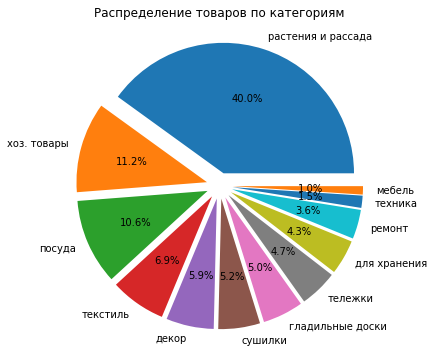

In [234]:
#Визуализируем распределение товаров по категориям
df_category.plot(kind='pie', subplots=True, figsize=(6, 6), autopct='%0.1f%%',explode = (0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1, 0.1,0.1, 0.1,0.1))
plt.title("Распределение товаров по категориям")
plt.ylabel("")
plt.show()

### Вывод по функциональной категоризации:

После категоризации выявились профильные товары магазина, они получили личные узкие категории:

    - растения и рассада 929 позиции
    - сумки-тележки 109 позиций
    - гладильные доски 117 позиции
    - сушилки 120 позиций
    - посуда и кухонные принадлежности 246 позиции
    - муляжи овощей/фруктов и искусственные цветы (декор) 137 позиций
    - товары для хранения одежды(вешалки, чехлы, коробки) 100 позиции
    
Остальные товары присутствуют в небольшом дополнительном товарном ассортименте и собраны в широкие категории:

    - хоз. товары (уборка, химия, хоз. принадлежности, товары для ванны и туалета) 260 позиций
    - текстиль (постельные принадлежности, коврики, халат) 160 позиций
    - товары для ремонта (инструмент, крепеж, детали и расходники) 84 позиций
    - бытовая техника 35 позиций
    - мебель 24 позиции

### 5.3 Категоризация по признаку оптовый/розничный. 
Любой товар, покупаемый в количестве более 1, считаем оптовым.

In [235]:
#функция категоризации на оптовые и розничные товары
def opt_cat(row):
    if row['quantity'] == 1:
        return False
    else:
        return True

df['opt'] = df.apply(opt_cat, axis = 1)

#Выведем на экран количество оптовых и розничных товаров
opt = df.groupby('product').agg({'opt':'first'}).groupby('opt').agg({'opt':'count'})
opt.columns = ['count']
display(opt.T)

opt,False,True
count,1770,551


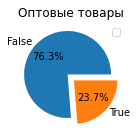

In [236]:
#визуализируем распределение
opt.plot(kind='pie', subplots=True, figsize=(2, 2), autopct='%0.1f%%',explode = (0.1,0.1))
plt.title("Оптовые товары")
plt.legend("")
plt.ylabel("")
plt.show()

### Вывод:
В статистике магазина пока мало заказов на более чем 1 единицу товара, всего 551 из 2321. 23,7%. Но нам уже есть, что предложить клиенту в качестве "акции".

### 5.4 Категоризация по признаку единичный/комплектный товар

Комплектные товары чаще покупают вместе с другими (карандаш+ластик, огурцы+помидоры). Найдем каждому товару самую эффективную пару в "комплект". 

1. Отбираем заказы с 2 и более товарами 
2. Определяем "основной" товар - самый дорогой в заказе 
3. Смотрим все товары, которые попадали с ним в одну корзину, сортируем по выручке 
4. Выбираем самый популярный

In [237]:
#получим список заказов, по которым будем проводить анализ на товары, которые чаще всего покупают вместе
df_complex = df.pivot_table(index = 'order_id', values = ['price'], aggfunc=['count'])
df_complex.columns = ['count']
df_complex = df_complex.query('count>1').sort_values('count', ascending = False).drop('count', 1)

#создаем пустой датафрейм пар "основной товар - дополнительный товар"
paired_prod = pd.DataFrame({'main_prod': [], 'paired_prod': []})

for i in df_complex.index: #для каждого заказа из списка
    df_order = df[df['order_id'] == i].sort_values(by='price', ascending = False).reset_index() #находим основной и дополнительный товар в заказе
    paired_prod.loc[i,'main_prod'] = df_order.loc[0][4]  #переносим пару в таблицу
    paired_prod.loc[i,'paired_prod'] = df_order.loc[1][4] #возможно это можно было сделать элегантней, но сегодня я зауряден

paired_prod = paired_prod.drop_duplicates(subset=['main_prod'], keep='last') #убираем дубликаты если на основной товар стало несколько пар

display(paired_prod.sample(5))
display(paired_prod.shape)

,main_prod,paired_prod
14770,"рассада капусты белокачанная средняя реванш, к...",рассада кабачка сорт белогор кассета 6 шт e6
69156,нож кухонный для овощей с деревянной ручкой 31...,кухонные ножницы webber из нержавеющей стали с...
68854,герань домашняя (пеларгония зональная) цветуща...,герань домашняя (пеларгония зональная) цветуща...
14835,портулак рассада однолетних цветов в кассете п...,петуния махровая рассада однолетних цветов в к...
69104,набор бокалов император 3 шт 170 мл 06707 e518...,набор стаканов для виски 300 мл 6 шт серия кар...


(287, 2)

## Вывод:
У магазина оказалось достаточно мало заказов с уникальными парными товарами: 287 из 2321. 12,4%.
Для товаров, по которым еще не набралась статистика парности можно предлагать товары из той же функциональной категории.

### 5.5 Категоризация по признаку сезонности (месяц)

Необходимо выяснить, в каком месяце каждый товар приносит самую высокую выручку.

In [238]:
best_month_prod = df.groupby('product').agg({'order_id':'first'}).reset_index()
best_month_prod.columns = ['prod','best_month']

def get_best_month(prod):
    df_season = df[df['product'] == prod].groupby('month').agg({'revenue':'sum'}).reset_index().sort_values(by='revenue', ascending=False)
    return df_season.loc[0][0]

best_month_prod['best_month'] = best_month_prod['prod'].apply(get_best_month)

display(best_month_prod.sample(10))
 

,prod,best_month
560,кодонанта укорененный черенок 1 шт,2
2112,"цинерария серебряная пыль 0,1 г 4660010770797",12
2228,штора для ванной spirella / спирелла peva hugo...,8
391,искусственный цветок гвоздика садовая пластико...,4
1348,рассада томата (помидор) джессика № 50 сорт ин...,4
711,"ложка столовая ripple сталь 3 мм, 3 шт, attrib...",10
1678,сумка-тележка хозяйственная багажная d-т125 кр...,8
1962,томата (помидор) оранжевый банан № 60 сорт инд...,4
2154,чехол для гладильной доски colombo persia beig...,1
73,бальзамин новогвинейский d-13 см ярко красный,2


### Вывод:
Каждому товару расчитан месяц, в который клиенты особенно им заинтересованы. Например "щетка для мытья окон" - в апреле, а муляжи фруктов - в октябре-ноябре, а рассаду в зависимости от сроков посева - с февраля по май. Теперь можно точечно предлагать клиенту нужную рассаду в нужный период.

Аналогичным способом можно найти лучший номер недели и день недели, но такая метрика имеет смысл при анализе значительно большего количества заказов.

### 5.6 Собираем сводную таблицу по товарам со всеми категориями

In [239]:
final_product = df.groupby('product').agg({'category':'first', 'order_id':'nunique', 'customer_id':'nunique', 
                                 'quantity':'sum','price':'max', 'revenue':'sum','opt':'first'}).reset_index().sort_values(by='order_id', ascending=False)
final_product.columns = ['product','category','orders','customers','quantity','price','revenue','opt']
final_product=final_product.set_index('product').join(paired_prod.set_index('main_prod')).reset_index()

final_product=final_product.set_index('product').join(best_month_prod.set_index('prod')).reset_index()

display(final_product.head(5))

,product,category,orders,customers,quantity,price,revenue,opt,paired_prod,best_month
0,пеларгония розебудная red pandora укорененный ...,растения и рассада,65,63,83,149,11191,False,пеларгония розебудная red pandora укорененный ...,2
1,пеларгония розебудная prins nikolai укорененны...,растения и рассада,55,54,64,135,8626,False,пеларгония розебудная queen ingrid укорененный...,2
2,пеларгония зональная диам. 12 см сиреневый пол...,растения и рассада,52,47,63,188,10780,False,пеларгония зональная диам. 12 см сиреневый про...,1
3,сумка-тележка 2-х колесная gimi argo синяя,тележки,47,43,47,1087,50405,False,герань домашняя (пеларгония зональная) цветуща...,1
4,пеларгония розебудная mary укорененный черенок,растения и рассада,39,35,47,135,6336,False,пеларгония тюльпановидная emma,2


In [240]:
final_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2321 entries, 0 to 2320
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   product      2321 non-null   object
 1   category     2321 non-null   object
 2   orders       2321 non-null   int64 
 3   customers    2321 non-null   int64 
 4   quantity     2321 non-null   int64 
 5   price        2321 non-null   int64 
 6   revenue      2321 non-null   int64 
 7   opt          2321 non-null   bool  
 8   paired_prod  287 non-null    object
 9   best_month   2321 non-null   int64 
dtypes: bool(1), int64(6), object(3)
memory usage: 165.6+ KB


### Общий вывод по категоризации

В результате мы разделили товары на категории по функциональным признакам и добавили ряд новых признаков

#### Функциональные категории:

После категоризации выявились профильные товары магазина, они получили личные узкие категории:

    - растения и рассада 930 позиции
    - сумки-тележки 109 позиций
    - гладильные доски 117 позиции
    - сушилки 120 позиций
    - посуда и кухонные принадлежности 246 позиции
    - муляжи овощей/фруктов и искусственные цветы (декор) 137 позиций
    - товары для хранения одежды(вешалки, чехлы, коробки) 100 позиции
    
Остальные товары присутствуют в небольшом дополнительном товарном ассортименте и собраны в широкие категории:

    - хоз. товары (уборка, химия, хоз. принадлежности, товары для ванны и туалета) 259 позиций
    - текстиль (постельные принадлежности, коврики, халат) 160 позиций
    - товары для ремонта (инструмент, крепеж, детали и расходники) 84 позиций
    - бытовая техника 35 позиций
    - мебель 24 позиции

Повторюсь, что такая оценка не очень корректна, так как мы совершаем "ошибку выжившего" и не видим товары, которые есть в ассортименте, но не были проданы ни разу за исследуемый период. Возможно, например, позиций мебели значительно больше, но по какой-то причине работают только акции на доски, сушилки, сумки-тележки и рассаду.

Так же товарам добавлены новые признаки:

- Оптовый/розничный товар 

- Единичный/комплектный товар 

- Сезонность (месяц наибольшей популярности)

Рекомендации по повышению количества товаров в заказе: в зависимости от даты покупки и основного товара в корзине предлагать клиенту дополнительные товары по следующему алгоритму:
   - Приоритет 1: Товары из той же функциональной категории
   - Приоритет 2: Если товар оптовый - предложить положить еще товаров этого наименования по сниженной цене
   - Приоритет 3: Если товар комплектный - предложить товар для полного комплекта
   - Приоритет 4: Предложить товары из сезонного ассортимента

## Шаг 6: Исследуем товарный ассортимент по категориям

In [241]:
df_by_category = df.groupby('category').agg({'quantity':'sum', 
                                          'order_id':'count',
                                          'product':'nunique',
                                          'price':'mean',
                                          'revenue':'sum'}).sort_values(by='revenue', ascending=False)
df_by_category.columns = ['quantity','orders','product','mean_price','revenue']

df_by_category['mean_price'] = df_by_category['mean_price'].astype(int)
df_by_category['revenue_part'] = (df_by_category['revenue'] / df_by_category['revenue'].sum()*100).round(1)
df_by_category['quantity_part'] = (df_by_category['quantity'] / df_by_category['quantity'].sum()*100).round(1)
df_by_category['product_part'] = (df_by_category['product'] / df_by_category['product'].sum()*100).round(1)
df_by_category['orders_part'] = (df_by_category['orders'] / df_by_category['orders'].sum()*100).round(1)
df_by_category['mean_quantity_in_order'] = (df_by_category['quantity'] / df_by_category['orders']).round(1)
df_by_category[['revenue','revenue_part','product','product_part','quantity','quantity_part','orders','orders_part','mean_price','mean_quantity_in_order']]

,revenue,revenue_part,product,product_part,quantity,quantity_part,orders,orders_part,mean_price,mean_quantity_in_order
category,,,,,,,,,,
тележки,683466,21.4,109,4.7,358,3.9,349,7.3,1940,1.0
растения и рассада,505729,15.8,929,40.0,3669,39.5,2493,51.8,149,1.5
хоз. товары,393230,12.3,260,11.2,977,10.5,383,8.0,674,2.6
текстиль,348943,10.9,160,6.9,504,5.4,202,4.2,933,2.5
сушилки,319518,10.0,120,5.2,309,3.3,283,5.9,1077,1.1
гладильные доски,292280,9.1,117,5.0,256,2.8,212,4.4,1258,1.2
посуда,188387,5.9,246,10.6,850,9.1,292,6.1,372,2.9
ремонт,142263,4.4,84,3.6,346,3.7,106,2.2,1205,3.3
для хранения,126636,4.0,100,4.3,550,5.9,131,2.7,449,4.2


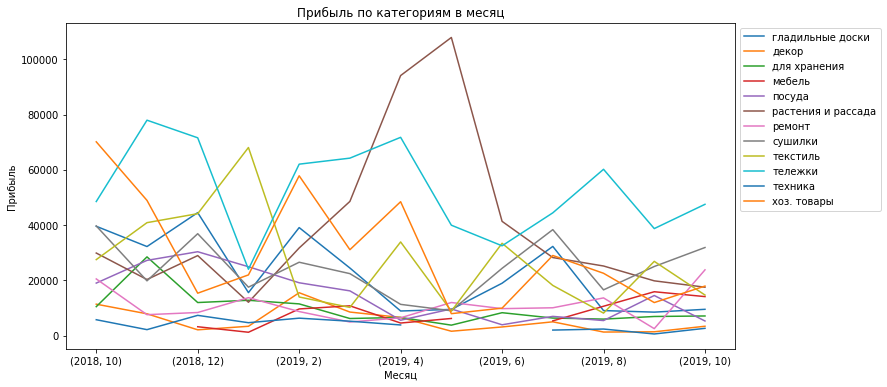

In [242]:
df.pivot_table(index=['year','month'], columns="category", values="revenue", aggfunc="sum").plot(figsize=(12,6))
plt.title('Прибыль по категориям в месяц')
plt.xticks(rotation=0)
plt.xlabel('Месяц')
plt.ylabel('Прибыль')
plt.legend(bbox_to_anchor=(1, 1));

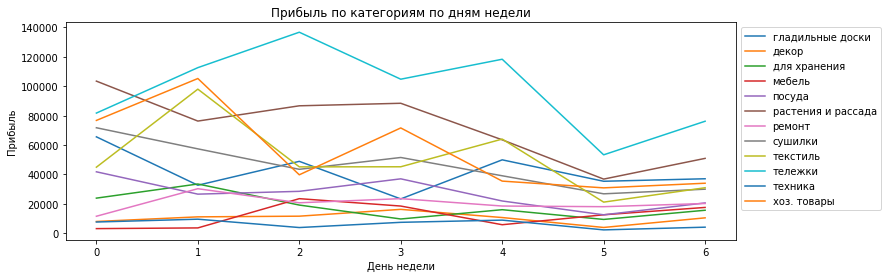

In [243]:
df.pivot_table(index=['weekday'], columns="category", values="revenue", aggfunc="sum").plot(figsize=(12,4))
plt.title('Прибыль по категориям по дням недели')
plt.xticks(rotation=0)
plt.xlabel('День недели')
plt.ylabel('Прибыль')
plt.legend(bbox_to_anchor=(1, 1));

### Вывод:

- При сегментировании товаров мы условно разделили категории на узкопрофильные и широкие дополнительные. Суммарная выручка показывает, что профильные категории тележки, рассада, текстиль, сушилки, гладильные доски имеют успех. 

- Категория тележки занимает всего 4,7% позиций товарного ассортимента, при этом дает 21,4% выручки. Эту категорию смело можно назвать профилем магазина и дальше расширять.

- Категория "рассада" имеет ту же целевую аудиторию. Она занимает более 40% товарного ассортимента и дает 15,9% выручки. На нее так же можно сделать ставку. По данным категориям можно сделать субъективные вывод о портрете клиента и опираться на него в выборе новых товаров. Но нужно учитывать, что данная категория имеют сильную сезонность, основные продажи приходят на апрель-май. Не следует исключать все категории и оставлять рассаду в одиночестве.

- Категория "хоз.товары" широкая, 11,2% товарного ассортимента, но назвать ее профилизирующей сложно, слишком большой разброс ассортимента. Категория, скорей всего, помогает держать магазин на плаву вне сезона.

- Другие узкие категории: текстиль, сушилки, гладильные доски примерно равноценны, дают 10,9, 10 и 9,1% выручки соответственно. Категории с хорошей выручкой, но делать на них ставку скорей всего не стоит.

- Узкая категория "посуда", на которую явно делалась ставка в закупке, занимает 10,6% товарного ассортимента, при этом дает менее 6% прибыли. Средняя стоимость товара одна из самых низких 372. Было продано 850 единиц товара этой категории, а выручка низкая. Плюс сложности хранения стеклянной посуды в товарном виде. Рекомендую сократить и переработать ее ассортимент в соответствии с портретом клиента.

- Аналогичная ситуация с товарами для хранения. Более 100 позиций вешалок и коробок дают 4% выручки. Рекомендую сократить эту категорию до объективного минимума.

- Категория декор выделяется низкой средней стоимостью товара: основа категории искусственные цветы и муляжи. При большом количестве проданных товаров этой категории 1380 - 14,9% от общего числа, выручка по категории 2,2%. Траты на обработку заказов по этой категории высоки, а выручка минимальна. Ее так же стоит сократить.

- Категории мебель и техника занимают всего по 0,5% товарного ассортимента и практически не дают выручки (2,2 и 1,3% соответственно), от них следует отказаться.

- Рекомендую изучить портрет клиента и добавить категории, соответствующие ему. Судя по всему это "дачники", люди предпенсионного и пенсионного возраста. А значит можно добавить в ассортимент дачных принадлежностей и товары категории "сад-огород". Все то, что создат дополнительный ассортимент к первым двум освновным категориям.

## Шаг 7: Формулируем и проверяем статистические гипотезы
Проверим 3 гипотезы:

- средняя выручка у заказов с дополнительными товарами равна средней выручке заказов с одним товаром
- средняя стоимость заказа за октябрь 2018 и октябрь 2019 одинаковая
- средняя выручка по оптовыим и розничным товарам одинакова

### Гипотеза 1

Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза: Средняя выручка у заказов с несколькими товарами равна средней выручке заказов с одним товаром.
- Альтернативная гипотеза: Средняя выручка у заказов с несколькими товарами не равна средней выручке заказов с одним товаром.

Проверяем гипотезу по t-критерию стьюдента

In [244]:
df_revenue = df.groupby('order_id').agg({'revenue':'sum','order_id':'count'})
df_revenue.columns = ['revenue','product_count']

along_revenue = df_revenue.query('product_count == 1')['revenue']
team_revenue = df_revenue.query('product_count != 1')['revenue']

alpha = .05
results = st.ttest_ind(
    along_revenue, 
    team_revenue)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.016698906453227243
Отвергаем нулевую гипотезу


### Гипотеза 2:

Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза: Средняя стоимость заказа за октябрь 2018 и октябрь 2019 одинаковая.
- Альтернативная гипотеза: Средняя стоимость заказа за октябрь 2018 и октябрь 2019 отличаются.

Проверяем гипотезу по t-критерию стьюдента

In [245]:
oct_2018_revenue = df.query('month == 10 & year == 2018')['revenue']
oct_2019_revenue = df.query('month == 10 & year == 2019')['revenue']

alpha = .05
results = st.ttest_ind(
    oct_2018_revenue, 
    oct_2019_revenue)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.0076156088215642865
Отвергаем нулевую гипотезу


### Гипотеза 3:

Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза: Выручка по оптовым и розничным товарам одинакова.
- Альтернативная гипотеза: Выручка по оптовым и розничным товарам различна.

Проверяем гипотезу по t-критерию стьюдента

In [246]:
opt_revenue = df.query('opt == True')['revenue']
retail_revenue = df.query('opt == False')['revenue']

alpha = .05
results = st.ttest_ind(
    opt_revenue, 
    retail_revenue)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  2.40954457702014e-10
Отвергаем нулевую гипотезу


### Результат проверги гипотез:
    
при уровне значимости альфа = 0.05

- Значение p по второй гипотезе:  0.0167

Отвергаем нулевую гипотезу, принимаем альтернативную: Средняя выручка у заказов с несколькими товарами не равна средней выручке заказов с одним товаром.

- Значение p по второй гипотезе:  0.0076

Отвергаем нулевую гипотезу, принимаем альтернативную: Средняя стоимость заказа за октябрь 2018 и октябрь 2019 отличаются.

- Значение p по третьей гипотезе:  2.409e-10

Отвергаем нулевую гипотезу, принимаем альтернативную: Средняя выручка по оптовым и розничным товарам различна.

## Шаг 8: Выводы и рекомендации.

### Предобработка данных

- Период анализа 395 дней и 16 часов: с октября 2018 по октябрь 2019
- В сырых данных содержалось 6737 строк:
   - 2451 уникальный покупатель
   - 2784 уникальных заказа
   - 2343 товарных позиции
- После удаления аномалий и мусора осталось 4810 строки:
   - 2418 уникальный покупатель
   - 2749 уникальных заказа
   - 2323 товарных позиции
- Устранены аномалии дублирующих заказов, выбросы по количеству товара в заказе. 
- Так же обнаружена аномалия присвоения одного номера заказа разным пользователям, но это не влияет на анализ товарного ассортимента, мы ее так же пропускаем.

### Исследовательский анализ

- Наблюдаем падение выручки в исследуемый период
- Матрица корреляции показала, что в исходном датафрейме нет параметров, коллелирующих между собой. Только те, что мы вывели сами из исходных, их корреляция логияна.
- Выручка по месяцам и неделям носит сезонный характер, в выходные выручка падает, освновные месяцы с высокими продажами: с февраля по май.

- Суммарная выручка за весь период: 3198985
- Число заказов: 2749
- Средняя цена товара: 645, но более 1700 товаров (74%) попали в ценовую категорию ниже среднего. Товары низкой ценовой категории преобладают в ассортименте.
- Средний чек: 1163, но большинство заказов так же меньше среднего чека (1946 из 2749)
- Среднее число позиций в заказе: 1.7
- Средняя цена товара: 645, но более 1700 товаров (74%) попали в ценовую категорию ниже среднего. Товары низкой ценовой категории преобладают в ассортименте.

<div class="alert alert-info"> <b>Комментарий:</b> В данном исследовании мы совершаем "ошибку выжившего", потому что не анализируем товары, которые вообще не продались, их нет в нашей базе. Для анализа товарного ассортимента необходима выгрузка по всему каталогу товаров.</div>

### Сравнительный анализ наслаивающихся периодов: октябрь 2018 и октябрь 2019. Поиск отличий как причин снижения выручки.

- При сравнении двух одинаковых периодов (октябрь 2018 и октябрь 2019) видим сильное падение выручки, практически на 40%. При этом число заказов снизилось не так значительно, только на 16%, а средний чек на 28%. Значительное изменение произошло в среднем количестве наименовании товаров в заказе: в 2018 в заказе присутствовало в среднем 2 товара, в 2019 только 1. Так же почти вдвое снизилось количество товаров одной позиции в заказе с 3.9 до 2.1.
#### Магазин потерял 40% выручки в первую очередь за счет отсуствия дополнительных товаров в заказе и снижения количества товаров одного типа в заказе.

### Сегментация
Выявлена основная проблема: среднее количество товаров в заказе низкое. Чтобы повысить выручку, нужно мотивировать клиента добавить в заказ дополнительные товары. Какие?

Чтобы выяснить это, добавим товарам несколько дополнительных признаков и сигментируем товары по ним:

- Функциональные категории (хоз. товары, растения, декор, инструменты).
Подбирать категории будем последовательно в ходе анализа товарного ассортимента.

- Оптовый/розничный товар
Оптовые товары обычно закупают партией, например семена редко покупают 1 упаковку. На такой товар имеет смысл ставить акции "при покупке 5 шт шестая бесплатно" и тп. Оптовым будем считать любой товар, который покупают более 1 в заказе. Границу акции определяем как "среднее количество товара за покупку" + 1 шт. То есть провоцируем на покупку как минимум еще 1 штуки.

- Единичный/комплектный товар
Комплектные товары чаще покупают вместе с другими (карандаш+ластик, огурцы+помидоры). В идеале найти каждому товару самую эффективную пару в "комплект". Поиск парного товара будем осуществлять по следующему алгоритму: 1. Отбираем заказы с 2 и более товарами 2. Определяем "основной" товар - самый дорогой в заказе 3. Смотрим все товары, которые попадали с ним в одну корзину, сортируем по выручке 4. Выбираем самый популярный

- Сезонность (месяц)
В зависимости от сезона предлагать товары из популярных в этот период (в мае закупают рассаду, в августе устройства для сбора урожая). Какую сезонность использовать: по месяцам или по номерам недель, необходимо выяснить по результам A/B теста после примерения рекомендаций.

### Категоризация по типам товара

После категоризации выявились профильные товары магазина, они получили личные узкие категории:

- растения и рассада 929 позиции
- сумки-тележки 109 позиций
- гладильные доски 117 позиции
- сушилки 120 позиций
- посуда и кухонные принадлежности 246 позиции
- муляжи овощей/фруктов и искусственные цветы (декор) 137 позиций
- товары для хранения одежды(вешалки, чехлы, коробки) 100 позиции


Остальные товары присутствуют в небольшом дополнительном товарном ассортименте и собраны в широкие категории:

- хоз. товары (уборка, химия, хоз. принадлежности, товары для ванны и туалета) 260 позиций
- текстиль (постельные принадлежности, коврики, халат) 160 позиций
- товары для ремонта (инструмент, крепеж, детали и расходники) 84 позиций
- бытовая техника 35 позиций
- мебель 24 позиции


### Категоризация по другим признакам

Так же товарам добавлены новые признаки:

- Оптовый/розничный товар 

В статистике магазина пока мало заказов на более чем 1 единицу товара, всего 551 из 2321. 23,7%. Но нам уже есть, что предложить клиенту в качестве "акции".

- Единичный/комплектный товар 

У магазина оказалось достаточно мало заказов с уникальными парными товарами: 287 из 2321. 12,4%.
Для товаров, по которым еще не набралась статистика парности можно предлагать товары из той же функциональной категории.

- Сезонность(месяц наибольшей популярности)

Каждому товару расчитан месяц, в который клиенты особенно им заинтересованы. Например "щетка для мытья окон" - в апреле, муляжи фруктов - в октябре-ноябре, а рассаду в зависимости от сроков посева - с февраля по май. Теперь можно точечно предлагать клиенту нужную рассаду в нужный период.

Аналогичным способом можно найти лучший номер недели и день недели, но такая метрика имеет смысл при анализе значительно большего количества заказов.

Рекомендации по повышению количества товаров в заказе: в зависимости от даты покупки и основного товара в корзине предлагать клиенту дополнительные товары по следующему алгоритму:
   - Приоритет 1: Товары из той же функциональной категории
   - Приоритет 2: Если товар оптовый - предложить положить еще товаров этого наименования по сниженной цене
   - Приоритет 3: Если товар комплектный - предложить товар для полного комплекта
   - Приоритет 4: Предложить товары из сезонного ассортимента
   
#### Сводная таблица с товарами и их категориями собрана в датафрейм final_product
   
### Исследуем товарный ассортимент по категориям

- При сегментировании товаров мы условно разделили категории на узкопрофильные и широкие дополнительные. Суммарная выручка показывает, что профильные категории тележки, рассада, текстиль, сушилки, гладильные доски имеют успех. 

- Категория тележки занимает всего 4,7% позиций товарного ассортимента, при этом дает 21,4% выручки. Эту категорию смело можно назвать профилем магазина и дальше расширять.

- Категория "рассада" имеет ту же целевую аудиторию. Она занимает более 40% товарного ассортимента и дает 15,9% выручки. На нее так же можно сделать ставку. По данным категориям можно сделать субъективные вывод о портрете клиента и опираться на него в выборе новых товаров. Но нужно учитывать, что данная категория имеют сильную сезонность, основные продажи приходят на апрель-май. Не следует исключать все категории и оставлять рассаду в одиночестве.

- Категория "хоз.товары" широкая, 11,2% товарного ассортимента, но назвать ее профилизирующей сложно, слишком большой разброс ассортимента. Категория, скорей всего, помогает держать магазин на плаву вне сезона.

- Другие узкие категории: текстиль, сушилки, гладильные доски примерно равноценны, дают 10,9, 10 и 9,1% выручки соответственно. Категории с хорошей выручкой, но делать на них ставку скорей всего не стоит.

- Узкая категория "посуда", на которую явно делалась ставка в закупке, занимает 10,6% товарного ассортимента, при этом дает менее 6% прибыли. Средняя стоимость товара одна из самых низких 372. Было продано 850 единиц товара этой категории, а выручка низкая. Плюс сложности хранения стеклянной посуды в товарном виде. Рекомендую сократить и переработать ее ассортимент в соответствии с портретом клиента.

- Аналогичная ситуация с товарами для хранения. Более 100 позиций вешалок и коробок дают 4% выручки. Рекомендую сократить эту категорию до объективного минимума.

- Категория декор выделяется низкой средней стоимостью товара: основа категории искусственные цветы и муляжи. При большом количестве проданных товаров этой категории 1380 - 14,9% от общего числа, выручка по категории 2,2%. Траты на обработку заказов по этой категории высоки, а выручка минимальна. Ее так же стоит сократить.

- Категории мебель и техника занимают всего по 0,5% товарного ассортимента и практически не дают выручки (2,2 и 1,3% соответственно), от них следует отказаться.

- Рекомендую изучить портрет клиента и добавить категории, соответствующие ему. Судя по всему это "дачники", люди предпенсионного и пенсионного возраста. А значит можно добавить в ассортимент дачных принадлежностей и товары категории "сад-огород". Все то, что создат дополнительный ассортимент к первым двум освновным категориям.

### Проверяем статистические гипотезы

- средняя выручка у заказов с дополнительными товарами равна средней выручке заказов с одним товаром
- средняя стоимость заказа за октябрь 2018 и октябрь 2019 одинаковая
- средняя выручка в будни и выходные равна

### Результат проверки гипотез:
    
при уровне значимости альфа = 0.05

- Значение p по второй гипотезе:  0.0167

Отвергаем нулевую гипотезу, принимаем альтернативную: Средняя выручка у заказов с несколькими товарами не равна средней выручке заказов с одним товаром.

- Значение p по второй гипотезе:  0.0076

Отвергаем нулевую гипотезу, принимаем альтернативную: Средняя стоимость заказа за октябрь 2018 и октябрь 2019 отличаются.

- Значение p по третьей гипотезе:  2.409e-10

Отвергаем нулевую гипотезу, принимаем альтернативную: Средняя выручка по оптовым и розничным товарам различна.
